In [1]:
# Some tunable parameters
import numpy as np

K = 5 # 'dimension' of the parameters (nb of coefficients to estimate)
functions = [1]+[np.cos,np.sin]*(K//2) # 
wavenumbers = [0]+[1+k//2 for k in range(K-1)] # wavenumbers inside the sinus function[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


# Physical model 
rho = 0.917 # ice density
gx,gy =5, -10 # x and y components for the gravity


def build_beta(coeffs):
    """
    Auxiliary function to build a function beta based on the theta coefficients in the arguments.
    We exponentiate because beta must be a positive function.

    Keyword arguments:
    coeffs -- float list of size K, the coefficients weigthing the truncated Fourier expansion functions

    Returns:
    beta -- one-dimensional function representing the basal drag factor
    """

    beta = lambda x: np.exp((coeffs[0] + sum([coeffs[k]*functions[k](wavenumbers[k]*2*np.pi*x[0]) for k in range(1,K)]))/K)

    return beta



# PDE Solver

In this section, we build our forward map, i.e. the solver for the Stokes flow.

It takes as argument the list of coefficients \theta that we will use to build the function β (basal drag factor on the lower boundary of the domain), and outputs the values of the velocity on the boundary.

In this section we also define the geometry of the domain (mesh, function spaces)

### Various imports

In [2]:
import dolfinx

In [3]:
#Other miscellaneous imports

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time


import ufl
from dolfinx import cpp as _cpp
from dolfinx import fem
from dolfinx import plot
from dolfinx.fem import (Constant, Function, FunctionSpace, dirichletbc,
                         extract_function_spaces, form, Expression,
                         locate_dofs_geometrical, locate_dofs_topological)
from dolfinx.io import XDMFFile
from dolfinx.mesh import (CellType, GhostMode, create_rectangle, locate_entities,
                          locate_entities_boundary, meshtags)

from dolfinx import geometry

from ufl import div, dx, grad, inner, Measure

from mpi4py import MPI
from petsc4py import PETSc

"""
# Setup environment for interactive plotting
!apt-get install -qq xvfb
!pip install pyvista panel -q

import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')
"""

"\n# Setup environment for interactive plotting\n!apt-get install -qq xvfb\n!pip install pyvista panel -q\n\nimport os\nos.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')\nos.environ['DISPLAY'] = ':99'\n\nimport panel as pn\npn.extension('vtk')\n"

### Study the impact of the mesh size

In [4]:
def solve_mesh(size_msh):
    
    # Create the mesh
    msh = create_rectangle(MPI.COMM_WORLD,
                       [np.array([0, 0]), np.array([1, 1])],
                       [size_msh, size_msh],
                       CellType.triangle, GhostMode.none)
    
    

    # We define the finite elements function space (Taylor Woods method)
    P2 = ufl.VectorElement("Lagrange", msh.ufl_cell(), 2)
    P1 = ufl.FiniteElement("Lagrange", msh.ufl_cell(), 1)
    mixed = ufl.MixedElement([P2, P1])

    V, Q = FunctionSpace(msh, P2), FunctionSpace(msh, P1)
    W = FunctionSpace(msh, mixed) # Defined Mixed Function space - needed for solving divergence at same time
    
    
    #Create the subdomains and space for Robin boundary condition in this problem

    tol = 1E-14 # tolerance (we cannot use strict equalities)

    boundaries = [(1, lambda x: abs(x[1])<= tol),   # Robin BC, at the bottom
                  (2, lambda x: abs(x[1]-1)<= tol)]   # Neumann BC, at  the surface


    # We now loop through all the boundary conditions and create MeshTags identifying the facets for each boundary condition
    facet_indices, facet_markers = [], []
    fdim = msh.topology.dim - 1
    for (marker, locator) in boundaries:
        facets = locate_entities(msh, fdim, locator)
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tag = meshtags(msh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


    # To debug boundary conditions, the easiest thing to do is to visualize the boundary in Paraview by writing the MeshTags to file
    msh.topology.create_connectivity(msh.topology.dim-1, msh.topology.dim)
    #with XDMFFile(msh.comm, "facet_tags.xdmf", "w") as xdmf:
    #    xdmf.write_mesh(msh)
    #    xdmf.write_meshtags(facet_tag)

    # Now we can create a custom integration measure ds, which can be used to restrict integration. 
    #If we integrate over ds(1), we only integrate over facets marked with value 1 in the corresponding facet_tag

    ds = Measure("ds", domain=msh, subdomain_data=facet_tag)
    
    
    
    
    # Define the class of boundary conditions 

    class BoundaryCondition():
        def __init__(self, type, marker, values):
            self._type = type
            if type == "Dirichlet":
                u_D = Function(V)
                u_D.interpolate(values)
                facets = facet_tag.find(marker)
                dofs = locate_dofs_topological(V, fdim, facets)
                self._bc = dirichletbc(u_D, dofs)

            elif type == "Neumann":
                self._bc = inner(values, v) * ds(marker)

            elif type == "Robin":
              #self._bc = values[0] * inner(u-values[1], v)* ds(marker)
              # slight modification: returns 2 integrals, one for the bilinear form a and one for the linear form L
                self._bc = values[0] * inner(u,v)* ds(marker), values[0] * inner(values[1], v)* ds(marker)
            else:
                raise TypeError("Unknown boundary condition: {0:s}".format(type))

        @property
        def bc(self):
            return self._bc

        @property
        def type(self):
            return self._type


    version = "sum"

    # We now define the bilinear and linear forms corresponding to the weak
    # mixed formulation of the Stokes equations in a blocked structure:

    # Define variational problem: Trial and test functions
    u, p = ufl.TrialFunctions(W)
    v, q = ufl.TestFunctions(W)

    # Define the source terms (based on tunable parameters at the top)
    f = Constant(msh, (PETSc.ScalarType(rho*gx), PETSc.ScalarType(rho*gy)))


    # Define the bilinear form
    a = inner(grad(u), grad(v)) * dx - inner(p, div(v)) * dx + inner(div(u), q) * dx

    # Define the linear form
    L = inner(f, v) * dx + inner(Constant(msh, PETSc.ScalarType(0)), q) * dx



    #-----------------SET THE BOUNDARY CONDITIONS FOR THE PROBLEM----------------------------------------------

    # Set the values for Neumann BC
    values_boundary_neumann = Constant(msh, (PETSc.ScalarType(0), PETSc.ScalarType(0))) # no stress --> tau = 0

    # Set the values for Robin BC
    beta = build_beta(theta)
    r = Function(Q)
    r.interpolate(beta)
    s = Constant(msh, (PETSc.ScalarType(0), PETSc.ScalarType(0)))
    values_boundary_robin = (r,s)

    # Gather the Boundary conditions
    boundary_conditions = [BoundaryCondition("Robin", 1, values_boundary_robin),
                        BoundaryCondition("Neumann", 2, values_boundary_neumann)]

    bcs = []
    for condition in boundary_conditions:
      if condition.type == "Dirichlet":
          bcs.append(condition.bc)

      elif condition.type == "Neumann":
          linear_term = condition.bc
          L+= linear_term

      elif condition.type == "Robin":

          bilinear_term, linear_term = condition.bc

          if version == "sum":
              a+= bilinear_term

          else:
              a[0].append(bilinear_term) # add the modification to bilinear form

          L+= linear_term   # add the modification to linear form

      else: 
          print("Unhandled condition type")



    #-----------------------------ASSEMBLE AND SOLVE-----------------------------------------------
    
    # Assemble LHS matrix and RHS vector
    a,L = form(a),form(L)

    A = fem.petsc.assemble_matrix(a, bcs=bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)

    fem.petsc.apply_lifting(b, [a], bcs=[bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS
    fem.petsc.set_bc(b, bcs)

    # Create and configure solver
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    ksp.getPC().setType("lu")
    ksp.getPC().setFactorSolverType("superlu_dist")

    # Compute the solution
    U = Function(W)
    
    start_time = time.time()
    ksp.solve(b, U.vector)
    solve_time = time.time()-start_time

    # Split the mixed solution and collapse
    uh = U.sub(0).collapse()
    ph = U.sub(1).collapse()



    #-----------------------------EVALUATE ON THE SURFACE AND OUTPUT VALUES-------------------------

    # Gather coordinates of mesh points that are at the surface

    facets_surface = facet_tag.find(2) # points at the surface boundary were marked with marker 2 (see previous cell)

    fdim = msh.topology.dim - 1
    msh.topology.create_connectivity(fdim, 0)

    num_facets_owned_by_proc = msh.topology.index_map(fdim).size_local
    geometry_entitites = dolfinx.cpp.mesh.entities_to_geometry(msh, fdim, np.arange(num_facets_owned_by_proc, dtype=np.int32), False)
    points = msh.geometry.x

    surface_coordinates=[]
    for e, entity in enumerate(geometry_entitites):
        if e in facets_surface:
            coord1, coord2 = points[entity][0], points[entity][1]
            surface_coordinates.append(coord1)
            surface_coordinates.append(coord2)

    surface_coordinates = np.unique(surface_coordinates, axis=0) # remove duplicates    

    # Prepare the tools to find corresponding cells

    bb_tree = geometry.BoundingBoxTree(msh, msh.topology.dim)
    cells = []

    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions(bb_tree, surface_coordinates)

    # Choose one of the cells that contains the point

    colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, surface_coordinates)

    for i, point in enumerate(surface_coordinates):

        if len(colliding_cells.links(i))>0:

            cells.append(colliding_cells.links(i)[0])



    u_values = uh.eval(surface_coordinates, cells)
    p_values = ph.eval(surface_coordinates, cells)

    return surface_coordinates, u_values, solve_time

In [5]:
# Run the analysis

sizes_mesh = [32, 50, 80, 100, 150]#, 200, 250]
theta = [-1, 0, 1, -1]
coords=[]
solutions = []
solve_times=[]

for sm in sizes_mesh:
    print(sm)
    surface_coordinates, u_values,solve_time = solve_mesh(sm)
    coords.append(surface_coordinates)
    solutions.append(u_values)
    solve_times.append(solve_time)

32
50
80
100
150


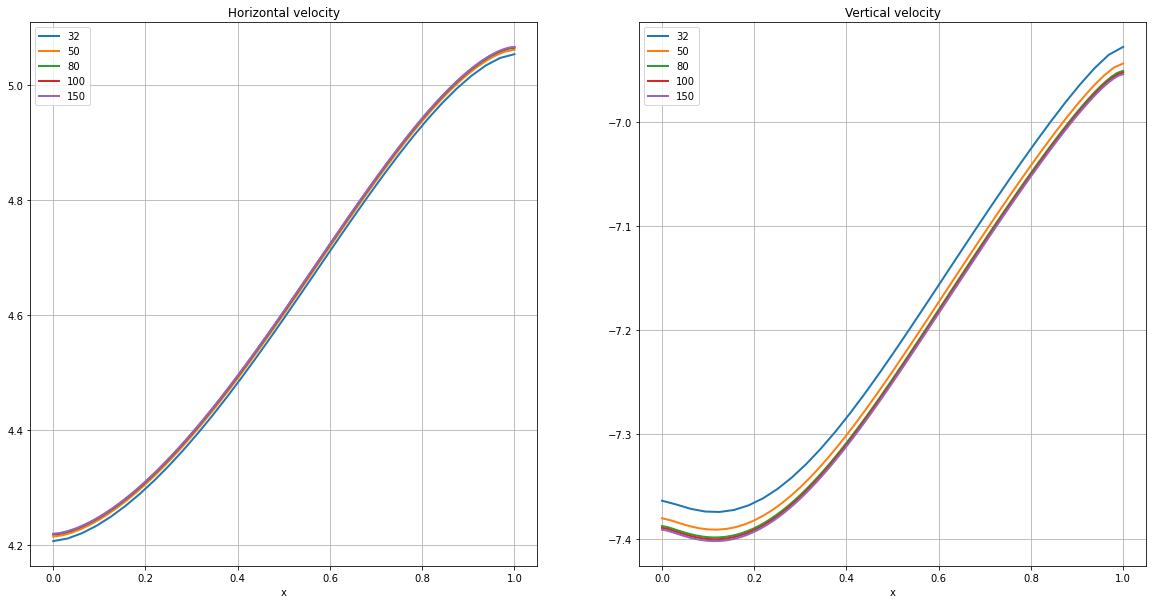

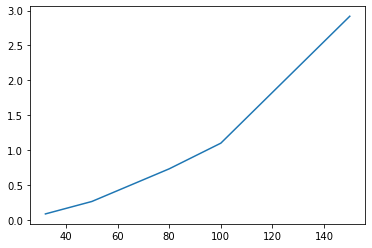

In [6]:
# Plot
fig = plt.figure(figsize=(20,10))

for i in range(len(sizes_mesh)):
    u_values = solutions[i]
    surface_coordinates = coords[i]
    velocity_x = [u_values[i][0] for i in range(len(coords[i]))]
    velocity_y = [u_values[i][1] for i in range(len(coords[i]))]
    x_value = [surface_coordinates[i][0] for i in range(len(coords[i]))]

    plt.subplot(121)
    plt.plot(x_value, velocity_x, linewidth=2, label=f"{sizes_mesh[i]}")

    plt.subplot(122)
    plt.plot(x_value, velocity_y, linewidth = 2, label=f"{sizes_mesh[i]}")

plt.subplot(121)
plt.title('Horizontal velocity')
plt.grid(True)
plt.xlabel("x")
plt.legend()

plt.subplot(122)
plt.title('Vertical velocity')
plt.grid(True)
plt.xlabel("x")
plt.legend()

plt.figure()
plt.plot(sizes_mesh, solve_times)

# If run in parallel as a python file, we save a plot per processor
#plt.savefig(f"velocity_plots.png")

## One function - Variational form and solving

In [57]:
# Create the mesh

size_msh = 50
msh = create_rectangle(MPI.COMM_WORLD,
                       [np.array([0, 0]), np.array([1, 1])],
                       [size_msh, size_msh],
                       CellType.triangle, GhostMode.none)
    
    
#Create the subdomains and space for Robin boundary condition in this problem

tol = 1E-14 # tolerance (we cannot use strict equalities)

boundaries = [(1, lambda x: abs(x[1])<= tol),   # Robin BC, at the bottom
              (2, lambda x: abs(x[1]-1)<= tol)]   # Neumann BC, at  the surface


# We now loop through all the boundary conditions and create MeshTags identifying the facets for each boundary condition
facet_indices, facet_markers = [], []
fdim = msh.topology.dim - 1

for (marker, locator) in boundaries:
    facets = locate_entities(msh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = meshtags(msh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


# To debug boundary conditions, the easiest thing to do is to visualize the boundary in Paraview by writing the MeshTags to file
msh.topology.create_connectivity(msh.topology.dim-1, msh.topology.dim)
#with XDMFFile(msh.comm, "facet_tags.xdmf", "w") as xdmf:
#    xdmf.write_mesh(msh)
#    xdmf.write_meshtags(facet_tag)

# Now we can create a custom integration measure ds, which can be used to restrict integration. 
#If we integrate over ds(1), we only integrate over facets marked with value 1 in the corresponding facet_tag

ds = Measure("ds", domain=msh, subdomain_data=facet_tag)

In [93]:
# We define the finite elements function space

P2 = ufl.VectorElement("Lagrange", msh.ufl_cell(), 2)
P1 = ufl.FiniteElement("Lagrange", msh.ufl_cell(), 1)

V = FunctionSpace(msh, P2)
Q = FunctionSpace(msh, P1)

In [180]:
# Define the class of boundary conditions 

class BoundaryCondition():
    def __init__(self, type, marker, values):
        self._type = type
        if type == "Dirichlet":
            u_D = Function(V)
            u_D.interpolate(values)
            facets = facet_tag.find(marker)
            dofs = locate_dofs_topological(V, fdim, facets)
            self._bc = dirichletbc(u_D, dofs)

        elif type == "Neumann":
            self._bc = inner(values, v) * ds(marker)

        elif type == "Robin":
          #self._bc = values[0] * inner(u-values[1], v)* ds(marker)
          # slight modification: returns 2 integrals, one for the bilinear form a and one for the linear form L
            self._bc = values[0] * inner(u,v)* ds(marker), values[0] * inner(values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))

    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type


version = "sum"

# Define variational problem: Trial and test functions
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Define the source terms (based on tunable parameters at the top)
f = Constant(msh, (PETSc.ScalarType(rho*gx),PETSc.ScalarType(rho*gy)))


# Define the bilinear form
bilinear = inner(grad(u), grad(v)) * dx

# Define the linear form
L = inner(f, v) * dx


def forward_map(theta,L=L):
    """
    Forward map for the inverse model. Maps the coefficients

    Keyword arguments:
    theta --
    
    Returns:

    """

    

    # We now define the bilinear and linear forms corresponding to the weak
    # mixed formulation of the Stokes equations in a blocked structure:






    #-----------------SET THE BOUNDARY CONDITIONS FOR THE PROBLEM----------------------------------------------

    # Set the values for Neumann BC
    values_boundary_neumann = Constant(msh, (PETSc.ScalarType(0), PETSc.ScalarType(0))) # no stress --> tau = 0

    # Set the values for Robin BC
    beta = build_beta(theta)
    
    r = Function(Q)
    r.interpolate(beta)
    s = Constant(msh, (PETSc.ScalarType(0), PETSc.ScalarType(0)))
    values_boundary_robin = (r,s)

    # Gather the Boundary conditions
    boundary_conditions = [BoundaryCondition("Robin", 1, values_boundary_robin),
                        BoundaryCondition("Neumann", 2, values_boundary_neumann)]

    bcs = []
    for condition in boundary_conditions:
        if condition.type == "Dirichlet":
            bcs.append(condition.bc)

        elif condition.type == "Neumann":
            linear_term = condition.bc
            L+= linear_term

        elif condition.type == "Robin":

            bilinear_term, linear_term = condition.bc

            if version == "sum":
                a = bilinear + bilinear_term

            else:
                a[0].append(bilinear_term) # add the modification to bilinear form


            L+= linear_term   # add the modification to linear form

        else: 
            print("Unhandled condition type")


    #-----------------------------ASSEMBLE AND SOLVE-----------------------------------------------

    # Assemble LHS matrix and RHS vector
    #a,L = form(a),form(L)

    #A = fem.petsc.assemble_matrix(a, bcs=bcs)
    #A.assemble()
    #b = fem.petsc.assemble_vector(L)

    # Create and configure solver
    #problem = fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    #uh = problem.solve()
    
    
    #-----------------------------ASSEMBLE AND SOLVE-----------------------------------------------

    # Assemble LHS matrix and RHS vector
    a,L = form(a),form(L)

    A = fem.petsc.assemble_matrix(a, bcs=bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)

    fem.petsc.apply_lifting(b, [a], bcs=[bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS
    fem.petsc.set_bc(b, bcs)

    # Create and configure solver
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    ksp.getPC().setType("lu")
    ksp.getPC().setFactorSolverType("superlu_dist")

    # Compute the solution
    uh = Function(V)
    ksp.solve(b, uh.vector)


    
    #-----------------------------EVALUATE ON THE SURFACE AND OUTPUT VALUES-------------------------

    # Gather coordinates of mesh points that are at the surface

    facets_surface = facet_tag.find(2) # points at the surface boundary were marked with marker 2 (see previous cell)

    fdim = msh.topology.dim - 1
    msh.topology.create_connectivity(fdim, 0)

    num_facets_owned_by_proc = msh.topology.index_map(fdim).size_local
    geometry_entitites = dolfinx.cpp.mesh.entities_to_geometry(msh, fdim, np.arange(num_facets_owned_by_proc, dtype=np.int32), False)
    points = msh.geometry.x

    surface_coordinates=[]
    for e, entity in enumerate(geometry_entitites):
        if e in facets_surface:
            coord1, coord2 = points[entity][0], points[entity][1]
            surface_coordinates.append(coord1)
            surface_coordinates.append(coord2)

    surface_coordinates = np.unique(surface_coordinates, axis=0) # remove duplicates    

    # Prepare the tools to find corresponding cells

    bb_tree = geometry.BoundingBoxTree(msh, msh.topology.dim)
    cells = []

    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions(bb_tree, surface_coordinates)

    # Choose one of the cells that contains the point

    colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, surface_coordinates)

    for i, point in enumerate(surface_coordinates):

        if len(colliding_cells.links(i))>0:

            cells.append(colliding_cells.links(i)[0])



    u_values = uh.eval(surface_coordinates, cells)
    #p_values = ph.eval(surface_coordinates, cells)

    return surface_coordinates, u_values

# MCMC

## Generating the synthetic data: "true coefficients" and the measurements¶

Values of the true coefficients set to [-0.32435513 -0.16224413  0.99076959 -0.35861425 -0.13409041]


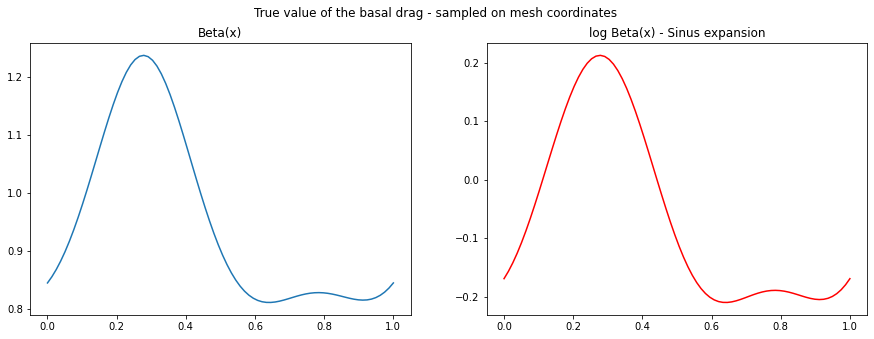

In [22]:
### Generating synthetic data

# Generate K coefficients following prior assumptions
theta_0 = np.random.normal(loc=0.0, scale=1, size=K)
#theta_0 = np.array([0.7, 0, 0, 0])

print(f"Values of the true coefficients set to {theta_0}")

# Build the true function
beta_0 = build_beta(theta_0)
interval = [(x,0) for x in np.linspace(0,1,size_msh)]

# Plot

plt.figure(figsize=(15,5))
plt.suptitle("True value of the basal drag - sampled on mesh coordinates")

plt.subplot(1,2,1)
plt.title("Beta(x)")
plt.plot([x[0] for x in interval], [beta_0(x) for x in interval])

plt.subplot(1,2,2)
plt.title("log Beta(x) - Sinus expansion")
plt.plot([x[0] for x in interval], [np.log(beta_0(x)) for x in interval],'r-')

plt.show()

In [182]:
# We repeat N experiments of measurements with the true coefficients and noise

# Retrieve the true values according to the model with true coefficients

surface_coordinates, u_values_true = forward_map(theta_0)
print(u_values_true)


# Simulate noisy observations
N= 1000
scale_noise = 0.001

observations = []

for n_obs in range(N):
    observation = u_values_true.copy()
    added_noise = np.random.normal(loc=0.0, scale=scale_noise, size=np.shape(observation)) # add gaussian noise at every evaluation
    observation+=added_noise

    observations.append(observation)
    
    


[[  7.1310331  -14.2620662 ]
 [  7.13104493 -14.26208986]
 [  7.13108041 -14.26216081]
 [  7.13113948 -14.26227896]
 [  7.13122207 -14.26244414]
 [  7.13132806 -14.26265612]
 [  7.13145731 -14.26291462]
 [  7.13160963 -14.26321927]
 [  7.13178482 -14.26356965]
 [  7.13198264 -14.26396527]
 [  7.1322028  -14.26440559]
 [  7.132445   -14.26488999]
 [  7.1327089  -14.26541779]
 [  7.13299413 -14.26598825]
 [  7.13330029 -14.26660057]
 [  7.13362694 -14.26725388]
 [  7.13397362 -14.26794725]
 [  7.13433985 -14.26867969]
 [  7.13472508 -14.26945016]
 [  7.13512877 -14.27025755]
 [  7.13555034 -14.27110069]
 [  7.13598918 -14.27197836]
 [  7.13644464 -14.27288928]
 [  7.13691606 -14.27383213]
 [  7.13740275 -14.27480551]
 [  7.13790399 -14.27580799]
 [  7.13841904 -14.27683809]
 [  7.13894713 -14.27789426]
 [  7.13948747 -14.27897494]
 [  7.14003925 -14.28007851]
 [  7.14060165 -14.28120329]
 [  7.1411738  -14.28234759]
 [  7.14175484 -14.28350968]
 [  7.14234389 -14.28468777]
 [  7.14294004

## Run the MCMC

In [170]:
# Auxiliary functions

def compute_loglikelihood(model_values, observations):
    """
    Keyword arguments:
    observations -- array, list of observations at the surface
    model_values -- array, outputs of the model (forward map) for the velocity at the surface

    Returns:
    loglikelihood -- int, the loglikelihood defined as in Richard Nickl's notes
    """
    loglikelihood = 0

    for i in range(len(observations)):
        observation = observations[i]
        #print(model_values, observation)
        #print(model_values - observation)
        #print(np.sum((model_values - observation)**2))
        loglikelihood+= np.sum((model_values - observation)**2)

    loglikelihood = -1/2 * loglikelihood  / (scale_noise**2)
    return loglikelihood



def compute_proposal_pcn(current_value, gamma):
    """
    Compute the proposal value for the coefficients of beta function for pCN scheme

    Keyword arguments:
    current_value -- array, current value of the Markov chain
    gamma -- float, step size

    Returns:
    proposal -- array, proposal for the next state of the Markov chain
    """
    #print("Current value: ", current_value)

    proposal = np.sqrt(1-2*gamma)*current_value + np.sqrt(2*gamma)*np.random.normal(loc=0.0, scale=scale_coefficients, size=len(current_value))
    
    #print("Proposal: ", proposal)

    return proposal



def metropolis_step(current_loglikelihood, proposal_loglikelihood, accept_reject):
    """
    Practice the Metropolis-Hastings step for the pCN scheme 
    
    Keyword arguments:
    current_loglikelihood -- int, current loglikelihood
    proposal_loglikelihood -- int, loglikelihood of the proposal

    Returns:
    boolean -- True if we accept the proposal, False otherwise
    """
    acceptance_probability = min(0, proposal_loglikelihood - current_loglikelihood)
    
    #print(f"Proposal likelihood: {proposal_loglikelihood}, Current likelihood: {current_loglikelihood}")
    #print("Accept proba:", acceptance_probability)
    # We draw a U([0,1]) r.v and return the proposal with probability acceptance_probability

    draw = np.random.uniform()
    print(np.exp(acceptance_probability))

    return np.log(draw) < acceptance_probability

In [ ]:
# RUN THE MARKOV CHAIN

# Parameters of the MCMC
n_iter = 1000 # number of iterations of the chain
gamma = 0.000000001 # step size
scale_coefficients = 0.1 # Gaussian prior for coefficients



# INITIALISATION

theta = np.random.normal(loc=0.0, scale=scale_coefficients, size=K)
#theta = np.array([10,-4,5,3])
theta = theta_0  #initialise at true value

# Compute the model and likelihood of this proposal
surface_coords,model_values = forward_map(theta)
current_loglikelihood = compute_loglikelihood(model_values, observations)

# Useful tables to store values

chain = np.zeros((n_iter,K)) # store the values of the chain
chain[0, :] = theta

accept_reject = np.zeros(n_iter, dtype=bool) # boolean table we use to track whether the proposal was accepted/rejected
accept_reject[0] = True 

likelihoods = np.zeros(n_iter)
likelihoods[0] = current_loglikelihood # store values of likelihoods


#--------------------ITERATE--------------------------------------------------

for iter in range(n_iter):

    if iter % 10 == 0:
        print(f"Iteration nb {iter} done")

    # Get the proposal for new value
    proposal = compute_proposal_pcn(theta, gamma)
    #print('Proposal: ', proposal)

    # Compute the model and likelihood of this proposal
    surface_coords, model_values = forward_map(proposal)
    proposal_loglikelihood = compute_loglikelihood(model_values, observations)

    # Metropolis step
    accept = metropolis_step(current_loglikelihood, proposal_loglikelihood, accept_reject)

    if accept:
        #print('accepted')
        accept_reject[iter]=True
        theta = proposal.copy()
        current_loglikelihood = proposal_loglikelihood

    else:
        #print("rejected")
        accept_reject[iter]=False


    chain[iter,:] = theta
    likelihoods[iter]= current_loglikelihood


Iteration nb 0 done
0.00017213126400453878
0.018771799362284937
0.04235642258954505
0.9366923943053407
0.47898292758583594
0.020228533189785222
1.0
0.21179442885443503
0.1662456814784571
0.0027568367744124685
Iteration nb 10 done
0.019192876449854672
0.9164594058430894
0.5442152371374261
1.0
0.9605848096359447
0.6552935528159646
1.0
0.002239121070173951
1.0
0.008961710630673933
Iteration nb 20 done
0.1459546654558591
0.48454518884251835
0.9993759895569206
1.0
4.1054053107448894e-08
9.894059636317104e-05
0.22978492220808625
0.3782512994211616
0.8623194593935534
8.666340383034115e-12
Iteration nb 30 done
0.006242032688850964
1.0
0.0002745358823022962
0.6807486393012182
6.230724944680966e-07
0.0157732487724167
1.0
0.00020147255608947401
0.3141716223454247
0.022479821532417822
Iteration nb 40 done
1.0
0.7651004244975358
1.0
1.0
5.952363230371502e-07
0.49561175695732024
0.11327719346510588
0.001659616333017748
1.7474979909714662e-08
0.35588628456019183
Iteration nb 50 done
1.0
0.58829385075

3.922561249135962e-05
0.011243004832372127
0.12407791944372465
0.912005967747714
0.0004917038496117433
0.0077133248536526205
Iteration nb 430 done
0.39051989658403324
0.030215472227830484
1.0
0.8986431565365028
0.0001234777162706139
0.11087158190777875
1.0
0.33692009154346136
0.18996336135848307
1.0
Iteration nb 440 done
0.42343781850243084
0.8656505259263896
3.394424544823189e-05
0.9080285079864493
1.0
0.002246021931537664
0.5223703833043043
2.457675476356985e-05
0.3522889050538932
2.0820749954275928e-15
Iteration nb 450 done
0.03610422387936399
0.0003537718119852987
0.7916538768777002
1.0
0.024291941767943706
0.04921705562360866
2.0459401179448796e-06
1.0
2.7197292468747744e-07
0.021952266065663924
Iteration nb 460 done
1.0
0.20189539463018466
1.743755355027774e-11
0.3320305935060803
3.4214052922291205e-05
0.04182038090064515
0.783089489842119
0.00019704517318593916
4.915302340050552e-07
0.25630546170052687
Iteration nb 470 done
0.002772443810890582
0.002721462117750742
1.0
0.0858224

In [40]:
# Save runs as numpy files

np.save(f"Schain_{n_iter}_{gamma}", np.array(chain))
np.save(f"Slikelihoods_{n_iter}_{gamma}", np.array(likelihoods))
np.save(f"Sacceptance_{n_iter}_{gamma}", np.array(accept_reject))

## Diagnostic

### Acceptance probability

Acceptance probability:  0.382


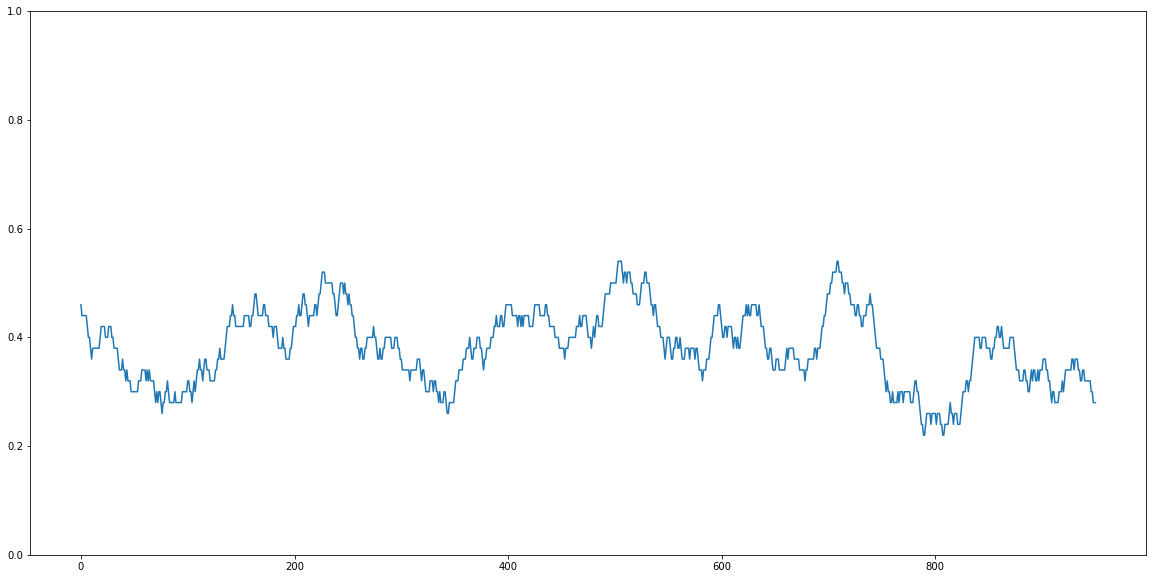

In [126]:
# Analysis of the acceptance probability:

print("Acceptance probability: ", sum(accept_reject)/len(accept_reject))

# Plot moving average of the acceptance probability (should stabilise as iteration increase)

def moving_average(l, width=50):
    """
    Compute the moving average of list l
    
    Keyword arguments:
    l -- float list, list of which we want to compute the moving average
    width -- int, window size of the moving average
    
    Returns:
    list of moving averages
    """
    return np.convolve(l, np.ones(width), 'valid') / width


movingAverage = moving_average([int(e) for e in accept_reject])

plt.figure(figsize=(20,10))
plt.ylim(0,1)
plt.plot(movingAverage)

### Likelihood

In [117]:
true_likelihood

-808306.8011128237

Text(0.5, 1.0, 'Evolution of the likelihood')

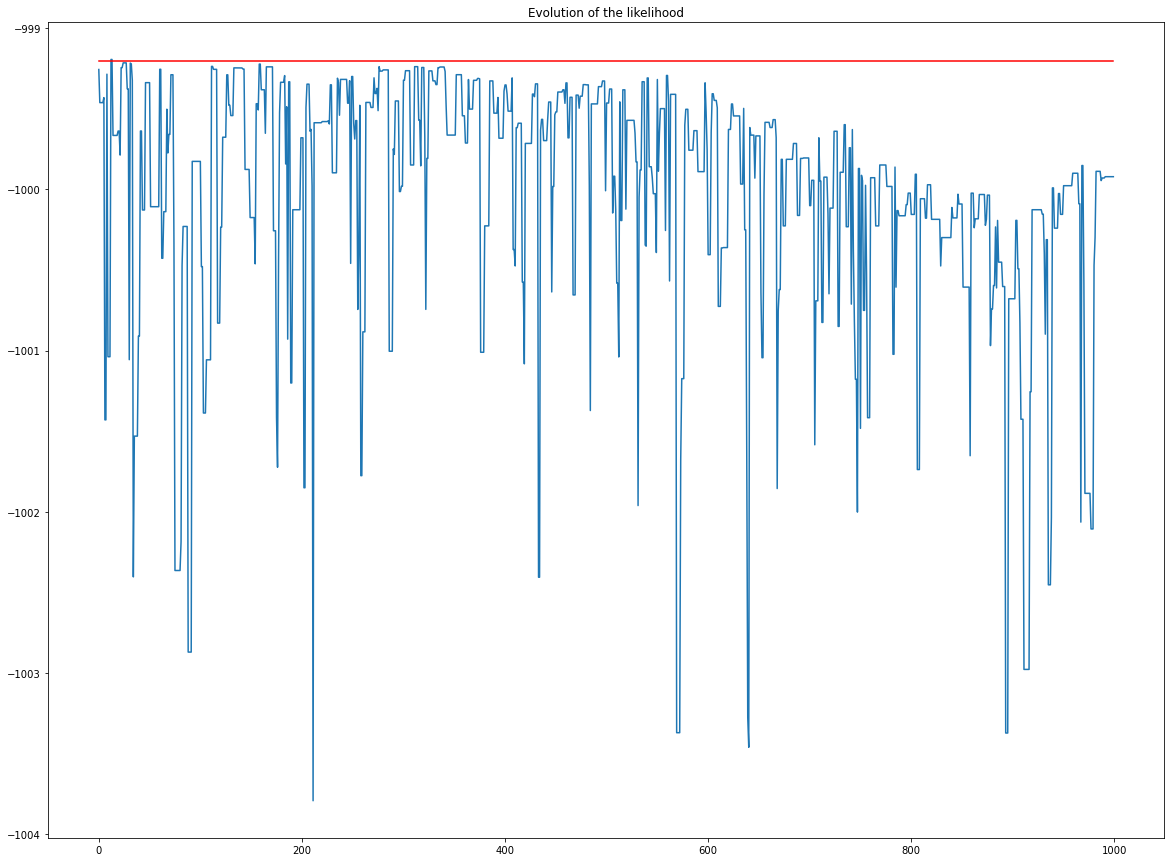

In [127]:
# Plot the evolution of the likelihood
plt.figure(figsize=(20,15))
plt.plot(likelihoods)

# Plot the true likelihood for reference
true_likelihood = compute_loglikelihood(u_values_true, observations)
plt.plot([true_likelihood]*n_iter, color = 'red')

plt.title("Evolution of the likelihood")

### Chain values

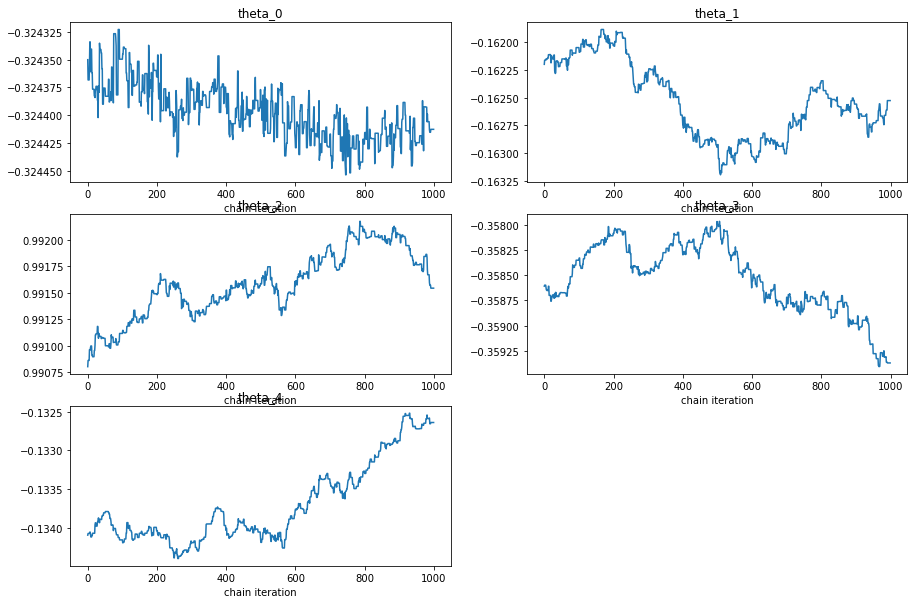

In [147]:
# Plot the chain so we can visually assess if converges

fig = plt.figure(figsize=(15,10))

plt.subplot(3, 2, 1)
plt.title('theta_0')
plt.xlabel('chain iteration')
plt.plot([theta[0] for theta in chain])
#plt.ylim(-10,10)

plt.subplot(3, 2, 2)
plt.title('theta_1')
plt.plot([theta[1] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.subplot(3, 2, 3)
plt.title('theta_2')
plt.plot([theta[2] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.subplot(3, 2, 4)
plt.title('theta_3')
plt.plot([theta[3] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.subplot(3, 2, 5)
plt.title('theta_4')
plt.plot([theta[4] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.show()

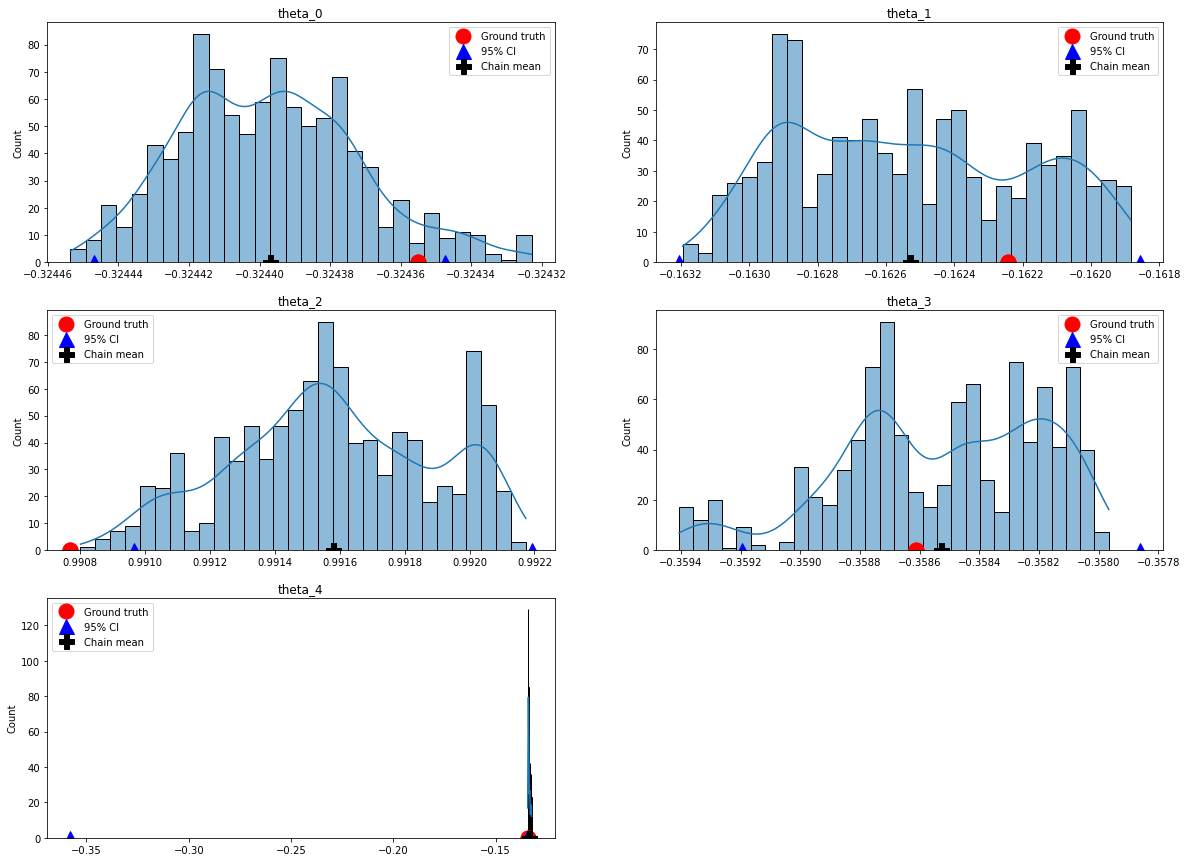

In [148]:
#  Plot histogram of chain, with mean + 95% confidence interval
import seaborn as sns
import scipy.stats as st

burnin = 10000
burnin=0

# Compute stats
confidence_intervals=[]
means = []
for i in range(K):
    
    # Define sample data
    data = [theta[i] for theta in chain][burnin:]
    means.append(np.mean(data))
  
    # Create 95% confidence interval
    confidence_interval = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),scale=np.std(data))
    confidence_intervals.append(confidence_interval)


#---------------------------------Plot histograms----------------------------------------
fig = plt.figure(figsize=(20,15))

plt.subplot(3, 2, 1)
plt.title('theta_0')
sns.histplot([theta[0] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[0], theta_0[0]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[0][0], confidence_intervals[0][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[0], means[0]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()

plt.subplot(3, 2, 2)
plt.title('theta_1')
sns.histplot([theta[1] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[1], theta_0[1]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[1][0], confidence_intervals[1][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[1], means[1]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()


plt.subplot(3, 2, 3)
plt.title('theta_2')
sns.histplot([theta[2] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[2], theta_0[2]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[2][0], confidence_intervals[2][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[2], means[2]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()


plt.subplot(3, 2, 4)
plt.title('theta_3')
sns.histplot([theta[3] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[3], theta_0[3]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[3][0], confidence_intervals[3][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[3], means[3]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()

plt.subplot(3, 2, 5)
plt.title('theta_4')
sns.histplot([theta[4] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[4], theta_0[4]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[4][0], confidence_intervals[3][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[4], means[4]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()


plt.show()

In [155]:
# Retrieving some stats - mean and confidence interval for every theta

import scipy.stats as st

# Run the loop
for i in range(K):
    
    # Define sample data
    data = [theta[i] for theta in chain][burnin:]
  
    # Create 95% confidence interval
    confidence_interval = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),scale=np.std(data))
    
    print(f"True value of the coefficient: {theta_0[i]}")
    print(f"Confidence interval: {confidence_interval}")
    print(f"Within confidence interval? {confidence_interval[0] <= theta_0[i] and confidence_interval[1] >= theta_0[i]}\n")

True value of the coefficient: -0.32435513472495914
Confidence interval: (-0.32444701445594226, -0.3243472839915693)
Within confidence interval? True

True value of the coefficient: -0.16224413248785485
Confidence interval: (-0.16320483042998338, -0.16185610667523578)
Within confidence interval? True

True value of the coefficient: 0.9907695870009766
Confidence interval: (0.9909667747227123, 0.9921910620573343)
Within confidence interval? False

True value of the coefficient: -0.35861425295890154
Confidence interval: (-0.3591968083037186, -0.3578610566061655)
Within confidence interval? True

True value of the coefficient: -0.1340904142321507
Confidence interval: (-0.13471257875743578, -0.13269638455452257)
Within confidence interval? True



In [165]:
# Auxiliary function to determine whether the chain sample fits in the 95% confidence interval

def within_confidence_interval(sample, chain):
    """
    Determines whether the sample sits within the confidence interval - to exclude extreme betas in reconstructions
    
    Keyword arguments:
    sample -- K-dim list, values of coefficients, drawn from the chain
    chain -- the whole chain
    
    Returns:
    boolean - whether all K components of the chain sample are within the 95% confidence interval
    """
    
    
    # Run the loop over dimensions of the parameter
    for k in range(K):
        
        data=[theta[k] for theta in chain]
        #print(data)
    
        # Create 95% confidence interval
        confidence_interval = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),scale=np.std(data))
        
        #print(confidence_interval)
        within_interval = confidence_interval[0] <= sample[k] and confidence_interval[1] >= sample[k]
        
        if not within_interval:
            #print(k, confidence_interval[0], sample[k], confidence_interval[1] )
            return False
    
    return True

In [163]:
burnin

0

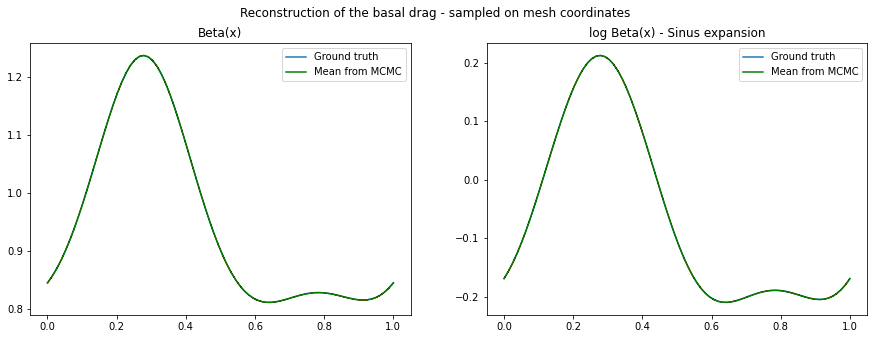

In [167]:
# Comparing true and simulated beta function. We plot the sinus expansion and the final beta function

import random

#-------------Start plotting with the true function-----------------------

# Build the true function
beta_0 = build_beta(theta_0)
interval = [(x,0) for x in np.linspace(0,1,size_msh)]

plt.figure(figsize=(15,5))
plt.suptitle("Reconstruction of the basal drag - sampled on mesh coordinates")

plt.subplot(1,2,1)
plt.title("Beta(x)")
plt.plot([x[0] for x in interval], [beta_0(x) for x in interval], label = "Ground truth")

plt.subplot(1,2,2)
plt.title("log Beta(x) - Sinus expansion")
plt.plot([x[0] for x in interval], [np.log(beta_0(x)) for x in interval], label = "Ground truth")


#-------------Add reconstruction from samples drawn from the chain---------------------------------

n_draws = 1000
all_betas = [0 for x in interval] # table to keep track of betas and compute mean at the end
all_log_betas = [0 for x in interval] # table to keep track of log betas and compute mean at the end
drawn = 0

while drawn < n_draws:

    draw = random.choice(chain)
    #print(drawn, draw)
    
    
    
    if within_confidence_interval(draw, chain[burnin:]):

        beta = build_beta(draw)
        beta_values = [beta(x) for x in interval]
        log_beta_values = [np.log(bv) for bv in beta_values]
        
        plt.subplot(1,2,1)
        plt.plot([x[0] for x in interval], beta_values, linewidth = 0.05, color='r')
        
        plt.subplot(1,2,2)
        plt.plot([x[0] for x in interval],log_beta_values, linewidth = 0.05, color='r')
        
        
        all_betas = [sum(x) for x in zip(all_betas, beta_values)] # update the list of all drawn betas
        all_log_betas = [sum(x) for x in zip(all_log_betas, log_beta_values)] # update the list of all drawn log betas
        
        drawn+=1 # update the count
        
        

# Add the empirical average to the plots

plt.subplot(121)
all_betas = [b/drawn for b in all_betas]
plt.plot([x[0] for x in interval], all_betas, color='g', label = "Mean from MCMC")
plt.legend()

plt.subplot(122)
all_log_betas = [b/drawn for b in all_log_betas]
plt.plot([x[0] for x in interval], all_log_betas, color='g', label = "Mean from MCMC")
plt.legend()

plt.show()

### Joint densities

         theta_0   theta_1   theta_2   theta_3
0      -1.915449 -1.263338  0.482457  1.422785
1      -1.915449 -1.263338  0.482457  1.422785
2      -1.915449 -1.263338  0.482457  1.422785
3      -1.990787 -1.151422  0.298438  1.248527
4      -1.990787 -1.151422  0.298438  1.248527
...          ...       ...       ...       ...
99996  -0.618159 -2.152168 -0.354562 -1.209012
99997  -0.498271 -2.138820 -0.380481 -1.176574
99998  -0.498271 -2.138820 -0.380481 -1.176574
99999  -0.498271 -2.138820 -0.380481 -1.176574
100000 -0.641798 -2.110137 -0.372410 -0.882077

[100001 rows x 4 columns]


<IPython.core.display.Javascript object>


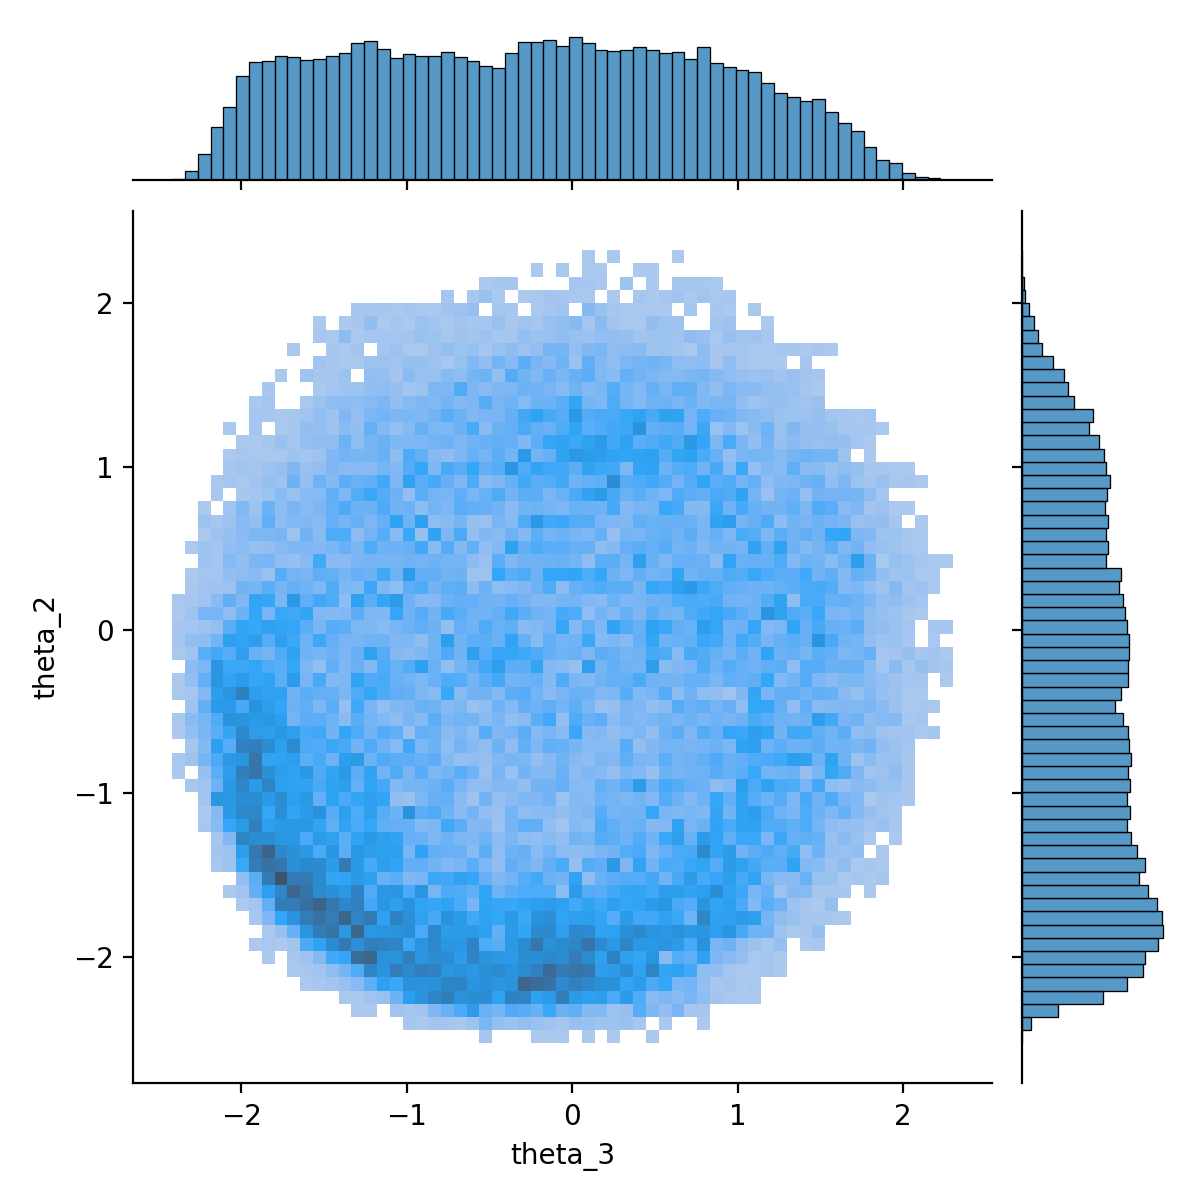

In [87]:
# Scatterplots

import pandas as pd
import seaborn as sns

data = np.array(chain)
df= pd.DataFrame(chain, columns = ["theta_0", "theta_1", "theta_2", "theta_3"], dtype=float)
print(df)


sns.jointplot(data=df, x='theta_3', y='theta_2', kind="hist")

<IPython.core.display.Javascript object>


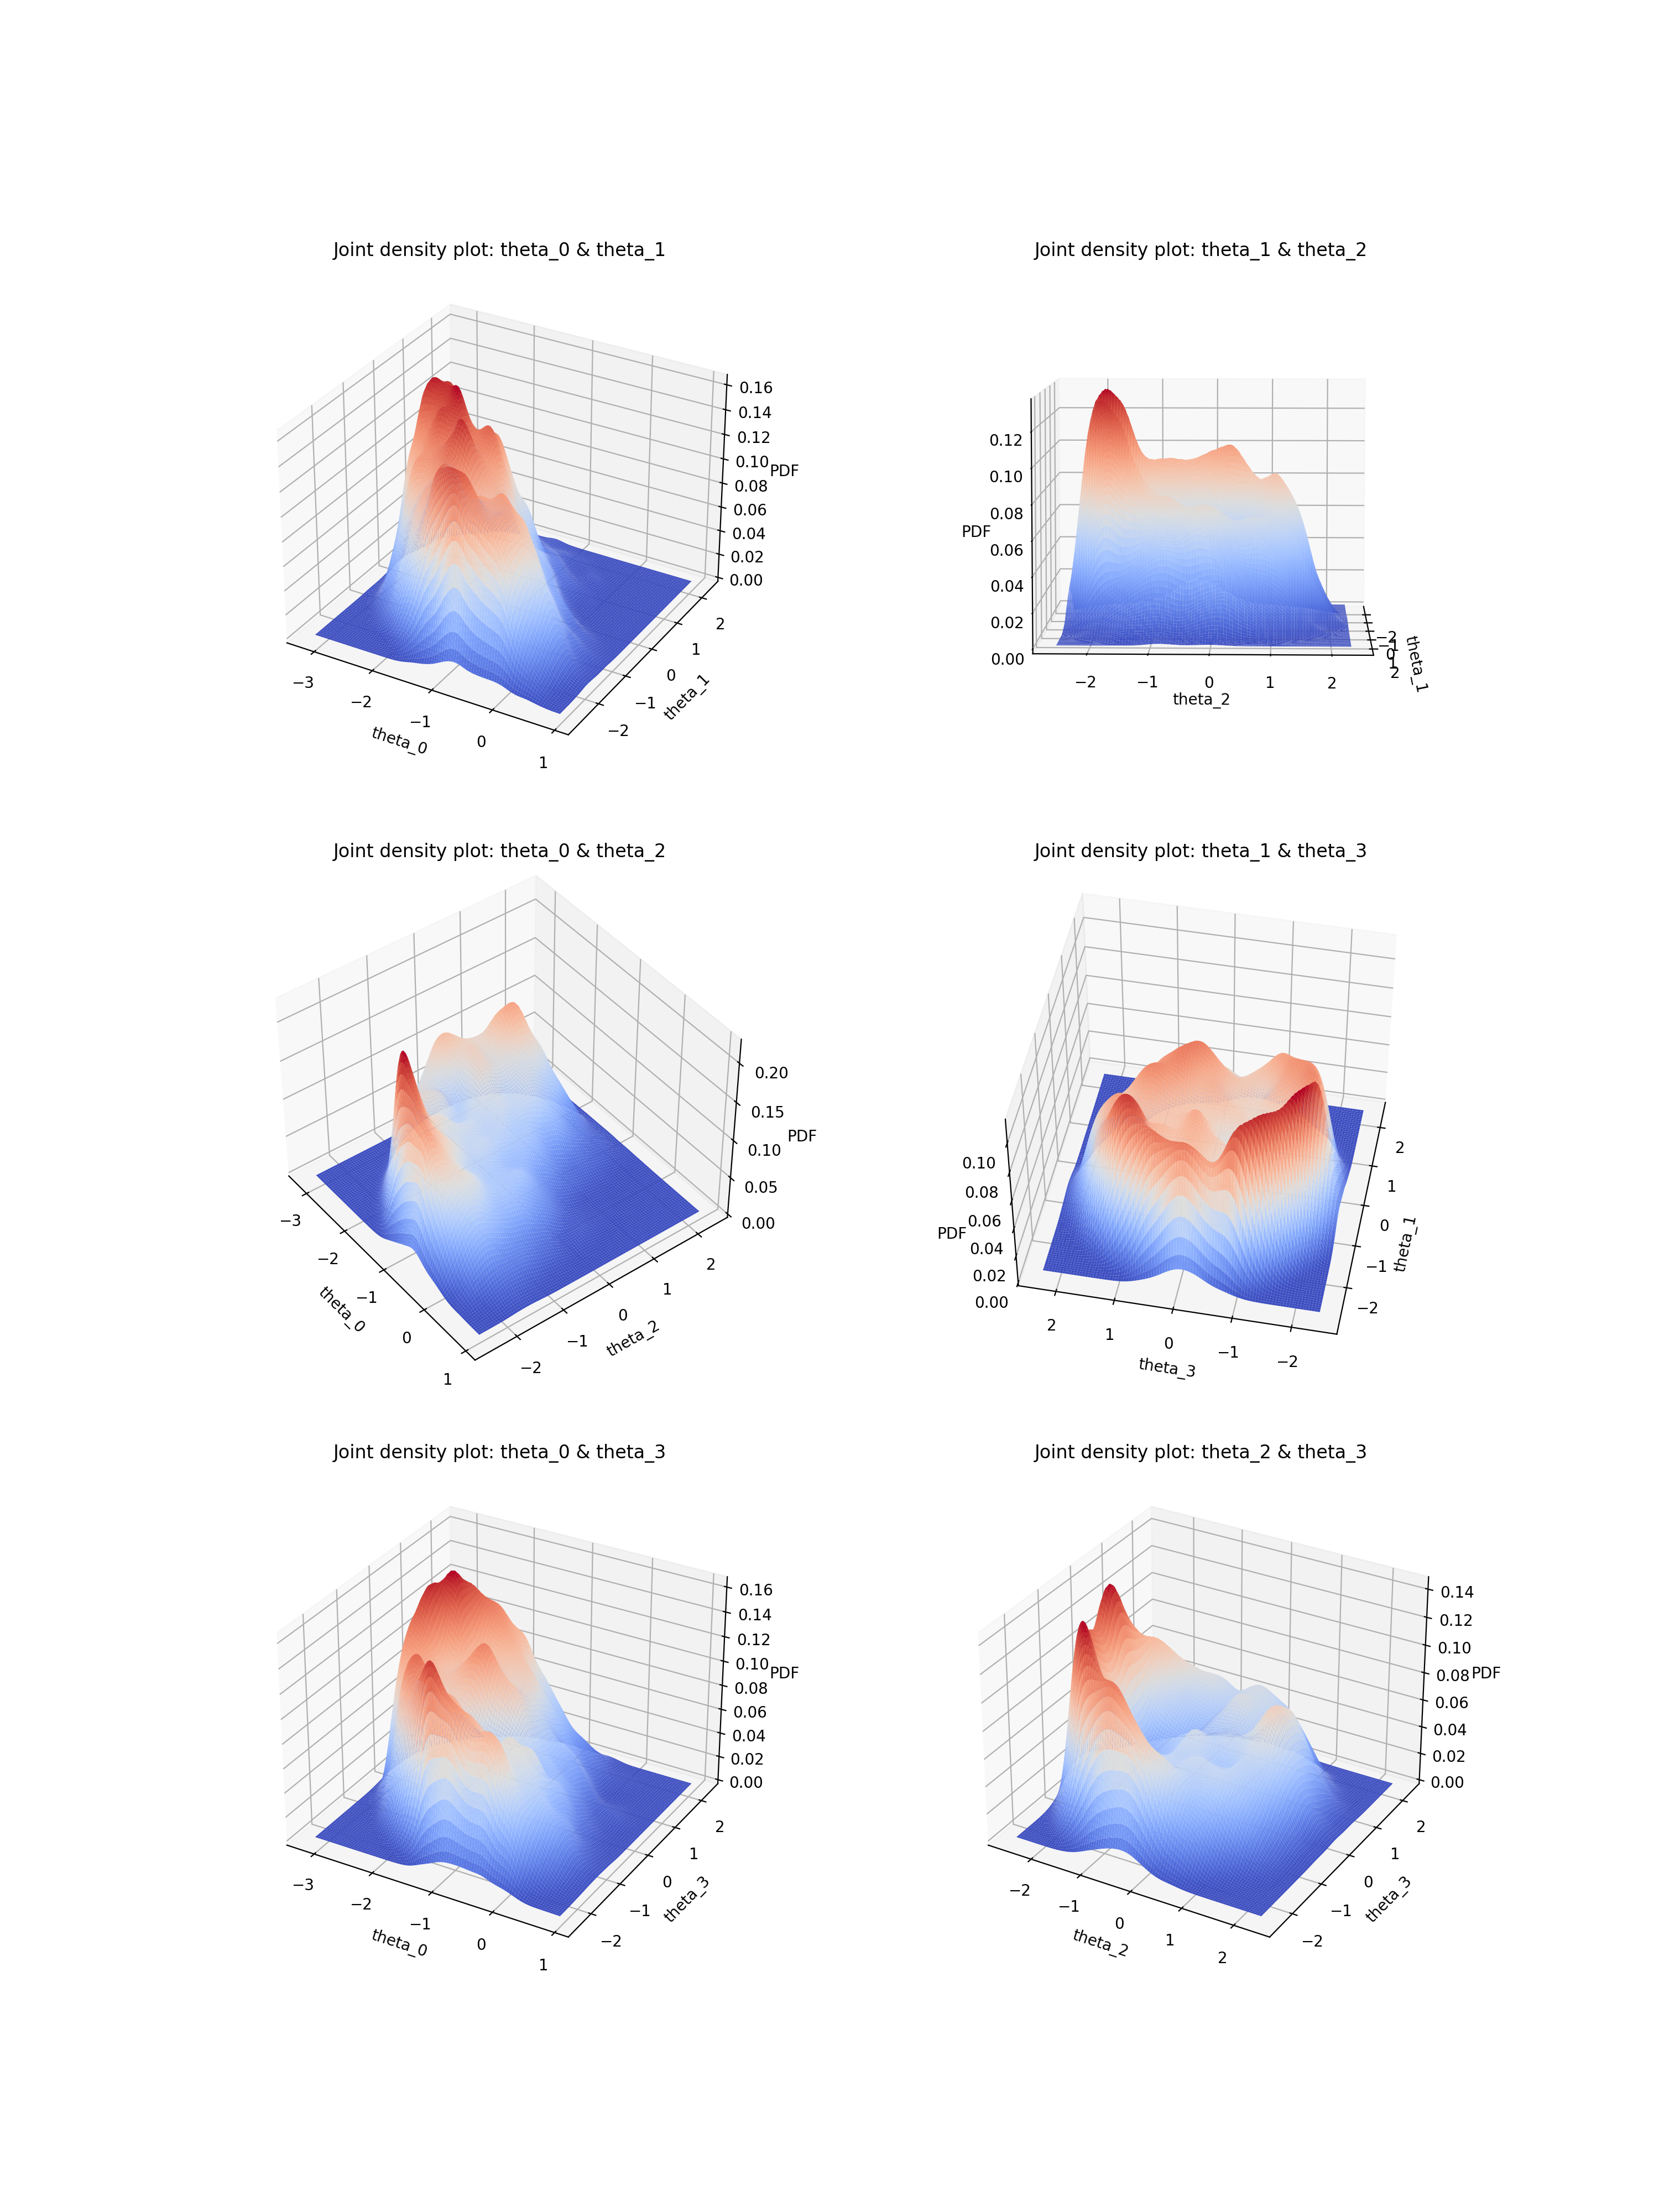

(3, 2)


In [85]:
# Displaying densities in 3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

%matplotlib notebook

fig, axs = plt.subplots(3, 2, figsize=(15, 20), subplot_kw={'projection': '3d'})
print(np.shape(axs))

# Loop over the different parameter combination

combinations = [('theta_0','theta_1'), ('theta_0','theta_2'), ('theta_0','theta_3'),
               ('theta_1','theta_2'), ('theta_1','theta_3'), ('theta_2','theta_3')]

row,col = 0, 0

for idx1,idx2 in combinations:
    x = np.array(df[idx1])
    y = np.array(df[idx2])
    ax = axs[row%3, col//3]
                
    # Create meshgrid
    xmin, xmax =np.min(x),np.max(x)
    ymin, ymax = np.min(y),np.max(y)
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

    # Create values
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    ax.set_xlabel(idx1)
    ax.set_ylabel(idx2)
    ax.set_zlabel('PDF')
    ax.set_title(f'Joint density plot: {idx1} & {idx2}')
    #fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF

    #ax.view_init(60, 35)
    
    # Update the row/col index
    row = row+1
    col = col+1
    
plt.show()

### Analyse surface velocity errors

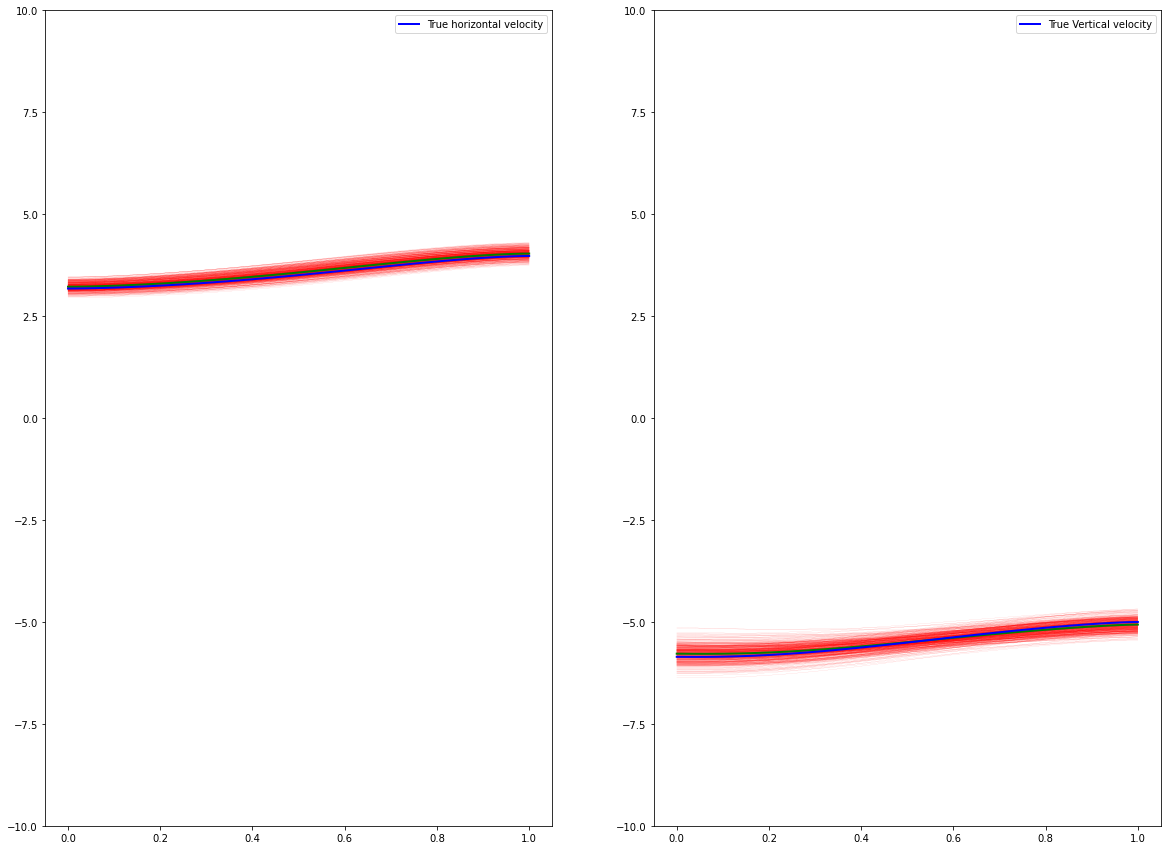

In [41]:
interval = [(k/size_msh, 0) for k in range(size_msh+1)]

fig = plt.figure(figsize=(20,15))

# Plot draws from the histograms on top
n_draws = 500

velocities_x = []
velocities_y = []

for d in range(n_draws):

    draw = random.choice(chain[burnin:])
    surface_coords,u_values = forward_map(draw)

    velocity_x = [u_values[i][0] for i in range(len(surface_coordinates))]
    velocity_y = [u_values[i][1] for i in range(len(surface_coordinates))]
    x_value = [interval[i][0] for i in range(len(surface_coordinates))]

    velocities_x.append(velocity_x)
    velocities_y.append(velocity_y)


    plt.subplot(121)  
    plt.plot(x_value, velocity_x, linewidth = 0.05, color='r')

    plt.subplot(122)    
    plt.plot(x_value, velocity_y,  linewidth = 0.05, color='r')


#Plot the average
avg_velocity_x = [np.mean([velocity_x[i] for velocity_x in velocities_x]) for i in range(len(surface_coordinates))]
avg_velocity_y = [np.mean([velocity_y[i] for velocity_y in velocities_y]) for i in range(len(surface_coordinates))]

plt.subplot(121)  
plt.plot(x_value, avg_velocity_x, linewidth = 2, color='g')

plt.subplot(122)    
plt.plot(x_value, avg_velocity_y, linewidth = 2, color='g')



# Plot the true function
surface_coordinates, u_values = forward_map(theta_0)
velocity_x = [u_values[i][0] for i in range(len(surface_coordinates))]
velocity_y = [u_values[i][1] for i in range(len(surface_coordinates))]
x_value = [interval[i][0] for i in range(len(surface_coordinates))]

plt.subplot(121)
plt.plot(x_value, velocity_x, "b", linewidth=2, label="True horizontal velocity")
plt.legend()
plt.ylim(-10,10)

plt.subplot(122)
plt.plot(x_value, velocity_y, "b", linewidth = 2, label="True Vertical velocity")
plt.legend()
plt.ylim(-10,10)


plt.show()


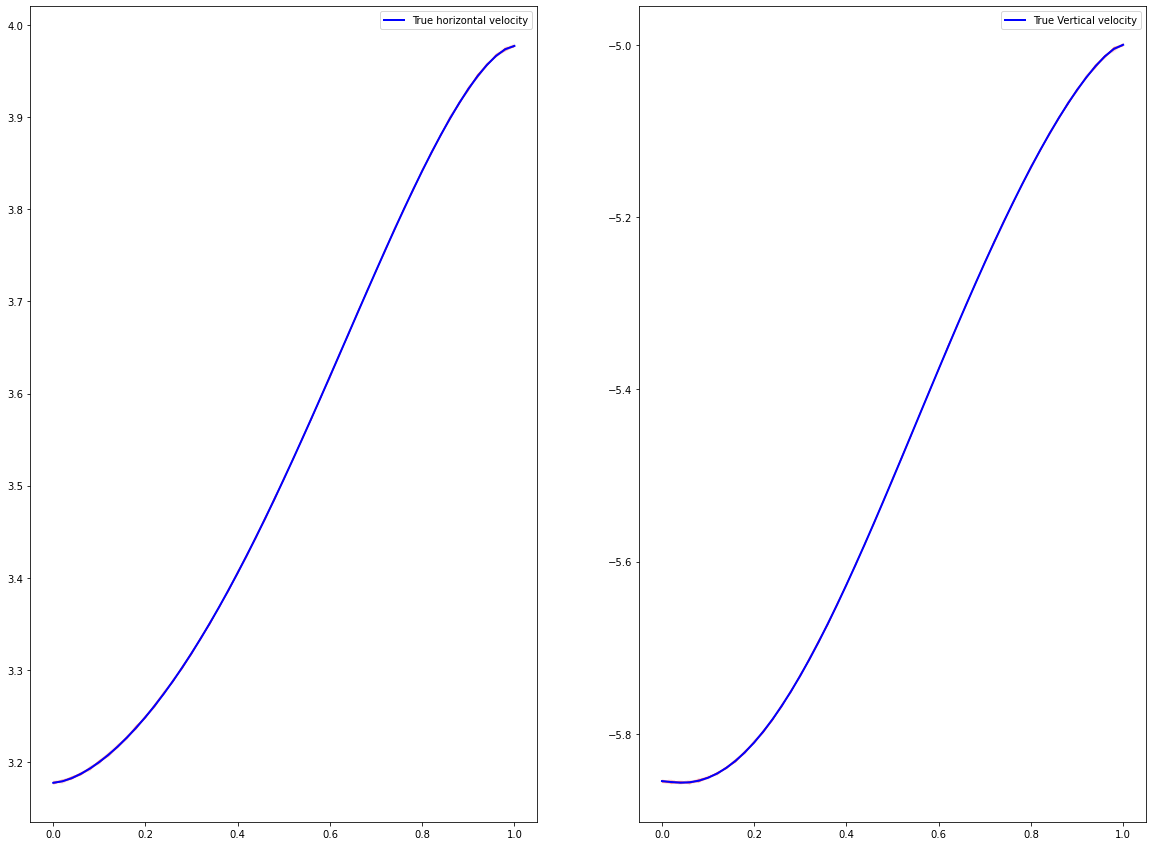

In [39]:
## Comparing with synthetic data

n_curves = 50

fig = plt.figure(figsize=(20,15))


for d in range(n_curves):
    draw = random.choice(np.arange(N))

    observation = observations[draw]
    velocity_x, velocity_y = [observation[i][0] for i in range(len(surface_coordinates))], [observation[i][1] for i in range(len(surface_coordinates))]

    plt.subplot(121)
    plt.plot(x_value, velocity_x, "r", linewidth=0.05)

    plt.subplot(122)
    plt.plot(x_value, velocity_y, "r", linewidth = 0.05)

     
    
# Plot true
velocity_x, velocity_y = [u_values_true[i][0] for i in range(len(surface_coordinates))], [u_values_true[i][1] for i in range(len(surface_coordinates))]

plt.subplot(121)
plt.plot(x_value, velocity_x, "b", linewidth=2, label="True horizontal velocity")
plt.legend()

plt.subplot(122)
plt.plot(x_value, velocity_y, "b", linewidth = 2, label="True Vertical velocity")
plt.legend()

plt.show()



## Make loops to test hyperparameters?

In [ ]:
def run_mcmc_trials(gamma, scale_coefficients, scale_noise):
    
    #---------------------------GENERATE FAKE DATA-----------------------------------------------------
    
    # Generating "fake" data / Generate K coefficients following prior assumptions
    theta_0 = np.random.normal(loc=0.0, scale=scale_coefficients, size=K)

    #print(f"Values of the true coefficients set to {theta_0}")
    
    # We repeat N experiments of measurements with the true coefficients and noise

    # Retrieve the true values according to the model with true coefficients
    surface_coordinates, u_values = forward_map(theta_0)

    # Simulate noisy observations
    N= 100
    observations = []

    for n_obs in range(N):
      observation = u_values.copy()
      added_noise = np.random.normal(loc=0.0, scale=scale_noise, size=np.shape(observation)) # add gaussian noise at every evaluation
      observation+=added_noise

      observations.append(observation)

    
    #--------------------------------------RUN THE MARKOV CHAIN----------------------------------------

    # Parameters of the MCMC
    n_iter = 10000 # number of iterations of the chain
    gamma = gamma


    # INITIALISATION

    theta = np.random.normal(loc=0.0, scale=scale_coefficients, size=K)

    # Compute the model and likelihood of this proposal
    surface_coords,model_values = forward_map(theta)
    current_loglikelihood = compute_loglikelihood(model_values, observations)

    # Useful tables to store values
    chain = [theta] # store the values of the chain
    accept_reject = [True] # boolean table we use to track whether the proposal was accepted/rejected
    likelihoods = [current_loglikelihood] # store values of likelihoods


    #--------------------ITERATE-----------------------------------------------------------------------

    for iter in range(n_iter):

      # Get the proposal for new value
      proposal = compute_proposal_pcn(theta, gamma)
      #print('Proposal: ', proposal)

      # Compute the model and likelihood of this proposal
      surface_coords, model_values = forward_map(proposal)
      proposal_loglikelihood = compute_loglikelihood(model_values, observations)

      # Metropolis step
      accept = metropolis_step(current_loglikelihood, proposal_loglikelihood, accept_reject)

      if accept:
        #print('accepted')
        accept_reject.append(True)
        theta = proposal.copy()
        current_loglikelihood = proposal_loglikelihood

      else:
        #print("rejected")
        accept_reject.append(False)

      chain.append(theta)
      likelihoods.append(current_loglikelihood)
        
    
    dict_ = {}
    dict_['gamma']=gamma
    dict_['scale_coefficients']=scale_coefficients
    dict_['scale_noise']=scale_noise
    dict_['accept_reject']=accept_reject
    dict_['acceptance_probability']= sum(accept_reject)/len(accept_reject)
    dict_['chain']=chain
    dict_['likelihoods']=likelihoods
    
    return dict_



In [ ]:
import pandas as pd

gammas = [0.001, 0.003, 0.01, 0.03, 0.1,0.3]
scales_coeff = [0.001, 0.003, 0.01, 0.03, 0.1,0.3,1,3,10,30,100]
scales_noise =[0.001, 0.003, 0.01, 0.03, 0.1,0.3,1,3,10,30,100]

df = pd.DataFrame()

for gamma in gammas:
    for scale_coefficients in scales_coeff:
        for scale_noise in scales_noise:
            
            print(f"Running with coefficients: gamma {gamma}, scale_coefficients {scale_coefficients}, scale_noise {scale_noise}.")
            dict_ = run_mcmc_trials(gamma, scale_coefficients, scale_noise)
            
            new_run = pd.DataFrame.from_dict(dict_)
            
            df = pd.concat([df, new_run])
            df.to_csv("output.csv", sep=';')  

In [ ]:
df['chain'].tolist())

In [ ]:
df.to_csv("output.csv", sep=';')  